In [1]:
import os
import gc
import wfdb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal
from sklearn.impute import SimpleImputer
from keras import Input, Model
from keras.api.optimizers import Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from keras.api.layers import Dense, Flatten, Conv1D, Concatenate, Reshape, LeakyReLU, BatchNormalization, Dropout, Conv1DTranspose, LSTM
from keras.api.metrics import Precision, Recall, Accuracy

%matplotlib inline

2025-01-19 05:17:12.418632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 05:17:12.440708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 05:17:12.448401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 05:17:12.466906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 05:17:13.303365: W tensorflow/compiler/tf2

In [2]:
ECG_names = sorted(os.listdir("dataset"))
ECG_names = [name for name in ECG_names if not any(exclude in name for exclude in ['02076', '02089', '02148', '02152'])]
scaler = StandardScaler()
all_ecgs = []

def downsample_ecg(ecg, samples=128):
    '''
    
    '''
    time_len, n_leads = ecg.shape
    new_ecg = np.zeros((samples, n_leads))
    for lead_idx in range(n_leads):
        lead_data = ecg[:, lead_idx]
        new_ecg[:, lead_idx] = signal.resample(lead_data, samples)
    return new_ecg


def load_data():
    '''
    
    '''
    combined_data = []
    CRFs = load_and_process_crf_data()
    idx = 0
    for ecgfilename in tqdm(ECG_names):
        if ecgfilename.endswith(".dat"):
            ecgfilename = ecgfilename.strip(".dat")
            data = __load_ecg_data(f"dataset/{ecgfilename}")[0]
            ecg_downsampled = downsample_ecg(data)
            all_ecgs.append(ecg_downsampled)
            combined_data.append((ecg_downsampled, CRFs.iloc[idx].values))
            idx += 1
    return combined_data


def __load_ecg_data(filename):
    '''
    
    '''
    x = wfdb.rdrecord(filename, sampfrom=20000, sampto=20000+(128*60),channels=[0,1,2])
    data = np.asarray(x.p_signal, dtype=np.float64)
    new_file = f"{filename}.hea"
    input_header_file = os.path.join(new_file)
    with open(input_header_file, 'r') as f:
        header_data = f.readlines()
    return data, header_data


def load_and_process_crf_data():
    '''
    
    '''
    CRFs = pd.read_csv(f"CRFs.csv")
    CRFs = CRFs[~CRFs['Record'].isin(['02076', '02089', '02148', '02152'])]
    CRFs = CRFs.drop(columns=['Record','IMT MAX', 'LVMi', 'EF'])
    CRFs['Gender'] = CRFs['Gender'].str.upper().map({'M':0, 'F':1})
    CRFs['Smoker'] = CRFs['Smoker'].str.upper().map({'NO':0, 'YES': 1})
    CRFs['Vascular event'] = CRFs['Vascular event'].str.lower().map({'none': 0, 'myocardial infarction': 1, 'stroke': 2, 'syncope': 3})
    num_imputer = SimpleImputer(strategy='mean')
    CRFs[['SBP', 'DBP']] = num_imputer.fit_transform(CRFs[['SBP', 'DBP']])
    num_cols = ['Age','Weight','Height','SBP','DBP','BSA','BMI']
    CRFs[num_cols] = scaler.fit_transform(CRFs[num_cols])
    # print(np.isnan(CRFs).any())
    # print(np.isinf(CRFs).any())
    return CRFs

def normalize_ecg(ecg, global_min, global_max):
    if global_max == global_min:
        return ecg
    ecg_norm = (ecg - global_min) / (global_max - global_min)
    ecg_norm = 2 * ecg_norm - 1
    return ecg_norm

In [3]:
combined_data = load_data()

all_ecgs = np.vstack(all_ecgs)
global_min = np.min(all_ecgs)
global_max = np.max(all_ecgs)

normalized_ecg_dataset = []
for ecg, crf in combined_data:
    ecg_norm = normalize_ecg(ecg, global_min=global_min,global_max=global_max)
    normalized_ecg_dataset.append((ecg_norm,crf))

  0%|          | 0/405 [00:00<?, ?it/s]

100%|██████████| 405/405 [00:00<00:00, 1852.20it/s]


In [4]:
def reverse_crf_normalization(crf,scaler : StandardScaler,col_names):
    original_crf = scaler.inverse_transform(crf)
    return pd.DataFrame(original_crf, columns=col_names)


def reverse_ecg_normalization(normalized_ecg, min_value, max_value):
    scaled_ecg = (normalized_ecg + 1) /  2
    original_ecg = scaled_ecg * (max_value - min_value) + min_value
    return original_ecg

In [5]:
def build_generator(latent_dim=100, cond_dim=10, ecg_length=128, n_leads=3, crf_dim=10):
    noise_input = Input(shape=(latent_dim,), name='noise input')
    input_condition = Input(shape=(cond_dim,), name='cond input')
    # Combined noise and condition to generate
    combined_input = Concatenate(name='concat_noise_cond')([noise_input, input_condition])
    # ECG leads generation
    x = Dense(1024, activation=LeakyReLU(0.2))(combined_input)
    x = Dense(512, activation=LeakyReLU(0.2))(x)
    x_ecg = Dense(16 * 64, activation=LeakyReLU(0.2))(x)
    x_ecg = Reshape((16,64))(x_ecg)
    x_ecg = LSTM(256, return_sequences=True)(x_ecg)  # Temporal modeling
    x_ecg = LSTM(128, return_sequences=True)(x_ecg)
    x_ecg = Conv1DTranspose(64, kernel_size=4, strides=2, padding='same')(x_ecg)  # 32 -> 64
    x_ecg = LeakyReLU(0.2)(x_ecg)
    x_ecg = Conv1DTranspose(32, kernel_size=4, strides=2, padding='same')(x_ecg)  # 64 -> 128
    x_ecg = LeakyReLU(0.2)(x_ecg)
    x_ecg = Conv1DTranspose(16, kernel_size=4, strides=2, padding='same')(x_ecg)
    x_ecg = LeakyReLU(0.2)(x_ecg)
    gen_ecg = Conv1D(filters=n_leads,kernel_size=7,padding='same',activation='tanh',name='gen_ecg')(x_ecg)
    # Clinical risk factors generation
    x_crf = Dense(128, activation='relu')(x)
    x_crf = Dense(64, activation='relu')(x_crf)
    gen_crf = Dense(crf_dim, activation='tanh')(x_crf)
    # Return model with inputs and outputs along with name
    generator = Model([noise_input, input_condition], [gen_ecg, gen_crf], name="Generator")
    return generator


In [6]:
def build_discriminator(ecg_length=128,n_leads=3,crf_dim=10,cond_dim=10):
    ecg_input = Input(shape=(ecg_length, n_leads), name='ecg_input')
    crf_input = Input(shape=(crf_dim,), name='crf_input')
    input_condition = Input(shape=(cond_dim,), name='cond_input')


    x_ecg = Conv1D(64,kernel_size=5, strides=2, padding='same')(ecg_input)
    x_ecg = LeakyReLU(negative_slope=0.2)(x_ecg)
    x_ecg = Conv1D(128, kernel_size=5, strides=2, padding='same')(x_ecg)
    x_ecg = LeakyReLU(negative_slope=0.2)(x_ecg)
    x_ecg = Conv1D(256, kernel_size=5, strides=2, padding='same')(x_ecg)
    x_ecg = LeakyReLU(negative_slope=0.2)(x_ecg)
    x_ecg = LSTM(128, return_sequences=False)(x_ecg)  # Temporal Modeling
    x_ecg = Flatten()(x_ecg)

    combined_input = Concatenate()([crf_input, input_condition])
    x_crf = Dense(64, activation=LeakyReLU(negative_slope=0.2))(combined_input)
    x_crf = Dense(64, activation=LeakyReLU(negative_slope=0.2))(x_crf)

    combined = Concatenate()([x_ecg, x_crf])
    x_combined = Dense(128, activation=LeakyReLU(0.2))(combined)
    x_combined = Dense(64, activation=LeakyReLU(0.2))(x_combined)

    # Output validity
    validity = Dense(1, activation='sigmoid', name='Validity')(x_combined)

    discriminator = Model([ecg_input, crf_input, input_condition], validity, name="Discriminator")
    
    return discriminator

In [7]:
def train_gan(generator : Model, discriminator : Model, dataset, gen_optimizer=None, disc_optimizer=None, checkpoint_manager : tf.train.CheckpointManager =None, 
              latent_dim=100, cond_dim=10, batch_size=32, epochs=1000):
    '''
    GAN training function. Builds the discriminator and generator networks.
    Compiles both networks, combined gen & discriminator network and discriminator network,
    sets discriminator to not trainable.

    Trains on the provided pre-processed dataset for the given number of epochs
    '''
    if gen_optimizer is None:
        gen_optimizer = Adam(1e-4, beta_1=0.5)
    if disc_optimizer is None:
        disc_optimizer = Adam(1e-6, beta_1=0.5)

    z = Input(shape=(latent_dim,))
    c = Input(shape=(cond_dim,))
    ecg_gen, crf_gen = generator([z, c])
    validity = discriminator([ecg_gen, crf_gen, c])
    combined = Model([z, c], validity, name='CombinedGAN')
    combined.compile(loss='binary_crossentropy',optimizer=gen_optimizer)
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])
    discriminator.trainable = False
    # Training loop
    real_label = tf.ones((batch_size, 1), dtype=tf.float32)
    fake_label = tf.zeros((batch_size, 1), dtype=tf.float32)
    loop_idx = 0
    for epoch in range(epochs):
        discriminator.trainable = True
        idx = np.random.randint(0, len(dataset), batch_size)
        real_ecgs = []
        real_crfs = []
        for i in idx:
            ecg_data, crf_data = dataset[i]
            real_crfs.append(crf_data)
            real_ecgs.append(ecg_data)
        real_ecgs = np.array(real_ecgs)
        real_ecgs = tf.convert_to_tensor(real_ecgs, dtype=tf.float32)
        real_crfs = np.array(real_crfs)
        real_crfs = tf.convert_to_tensor(real_crfs, dtype=tf.float32)

        z_rand = np.random.normal(0, 1, (batch_size, latent_dim))
        z_rand = tf.convert_to_tensor(z_rand, dtype=tf.float32)
        ecg_fake, crf_fake = generator.predict([z_rand, real_crfs])
        ecg_fake = tf.convert_to_tensor(ecg_fake, dtype=tf.float32)
        crf_fake = tf.convert_to_tensor(crf_fake, dtype=tf.float32)
        d_loss_real = discriminator.train_on_batch([real_ecgs, real_crfs, real_crfs], real_label)
        d_loss_fake = discriminator.train_on_batch([ecg_fake, crf_fake, real_crfs], fake_label)
        
        discriminator.trainable = False
        z_rand = np.random.normal(0, 1, (batch_size,latent_dim))
        z_rand = tf.convert_to_tensor(z_rand, dtype=tf.float32)
        g_loss = combined.train_on_batch([z_rand, real_crfs], real_label)

        if epoch % 50 == 0:
                if plt.fignum_exists(loop_idx-1):
                    plt.close(loop_idx-1)
                plt.figure(loop_idx, figsize=(15, 10))
                for lead in range(3):
                    original_ecg = reverse_ecg_normalization(ecg_fake[0,:,lead], global_min, global_max)
                    plt.subplot(3, 1, lead + 1)
                    plt.plot(original_ecg)
                    plt.title(f"Lead {lead + 1}")
                plt.draw()
                plt.pause(0.001)
                plt.show(block=False)
                loop_idx += 1

        if checkpoint_manager is not None and epoch % 50 == 0:
            ckpt_save_path = checkpoint_manager.save(checkpoint_number=epoch)
            print(f"Checkpoint saved at epoch {epoch}: {ckpt_save_path}")
            gc.collect()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | "f"D Loss: Real={d_loss_real[0]:.4f}, Fake={d_loss_fake[0]:.4f} | "
                  f"G Loss={g_loss:.4f}")

    
    combined.save(f"gan/Model.keras")

I0000 00:00:1737263835.370096  928782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737263835.400812  928782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737263835.400892  928782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737263835.403208  928782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737263835.403280  928782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Checkpoint restored from: ./checkpoints/ckpt-200


/home/elukbog/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['noise input', 'cond input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2025-01-19 05:17:17.091060: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1737263837.191159  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.225301  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.226855  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.228213  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.232488  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.2337

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


W0000 00:00:1737263837.306704  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.319374  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.327340  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.328219  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.359844  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.377278  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.377929  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.378590  929111 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737263837.379206  929111 gp

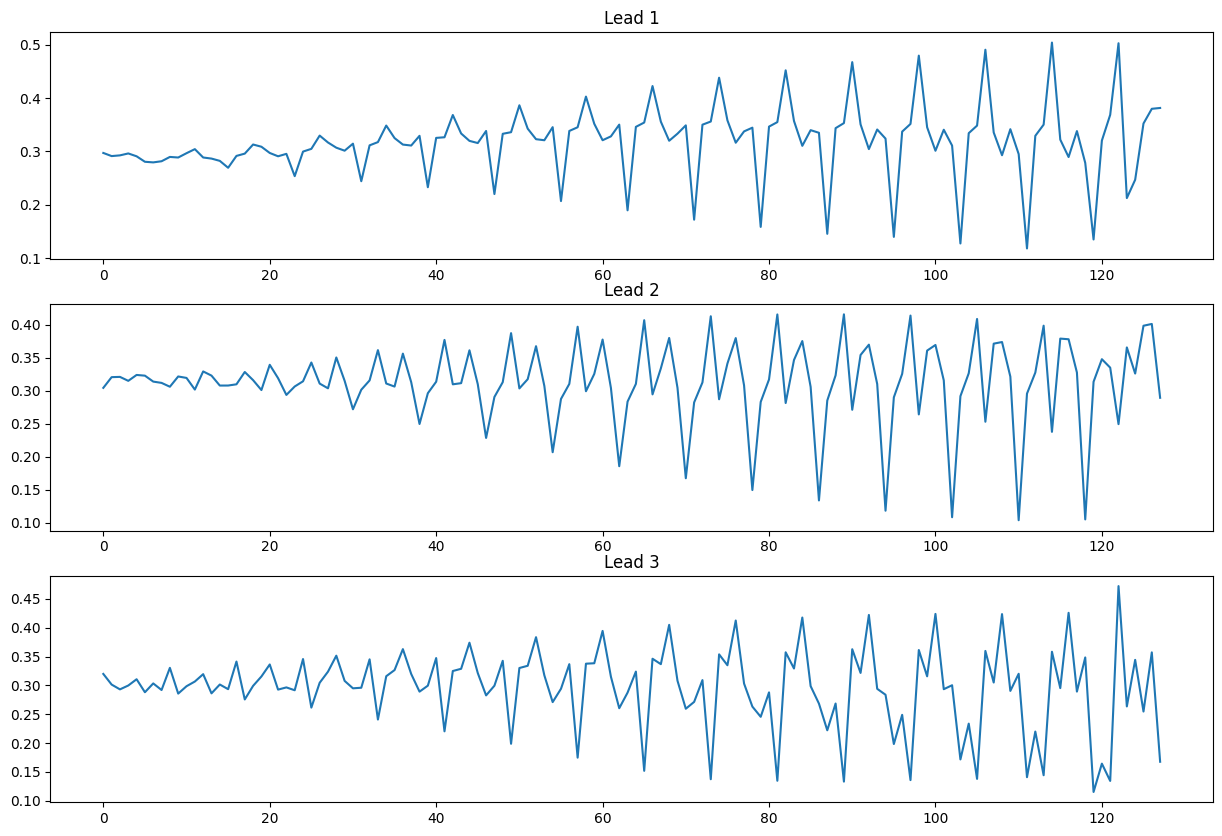

Checkpoint saved at epoch 0: ./checkpoints/ckpt-0
Epoch 0 | D Loss: Real=0.6706, Fake=0.7289 | G Loss=0.6135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 10 | D Loss: Real=0.7204, Fake=0.7238 | G Loss=0.6061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 20 | D Loss: Real=0.7192, Fake=0.7210 | G Loss=0.6054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━

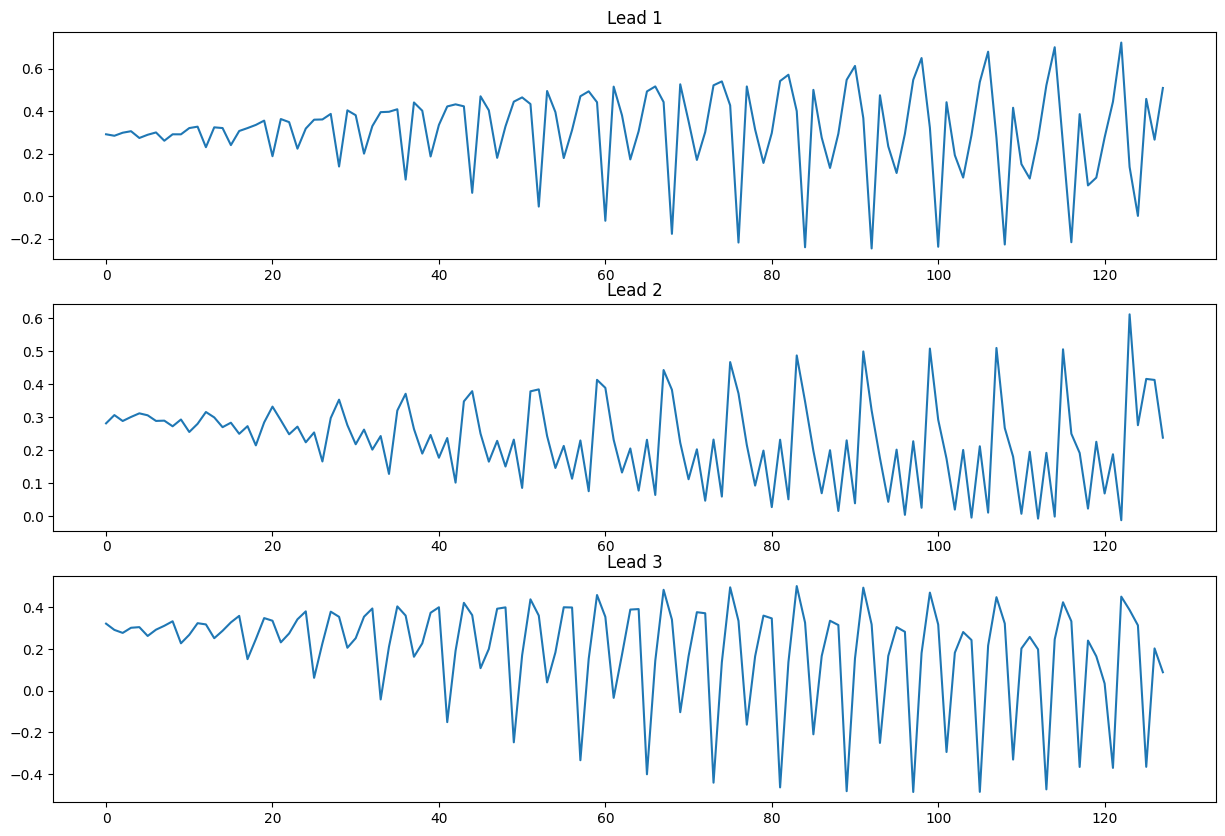

Checkpoint saved at epoch 50: ./checkpoints/ckpt-50
Epoch 50 | D Loss: Real=0.7189, Fake=0.7196 | G Loss=0.6075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 60 | D Loss: Real=0.7186, Fake=0.7193 | G Loss=0.6072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 70 | D Loss: Real=0.7187, Fake=0.7192 | G Loss=0.6070
1/1 ━━━━

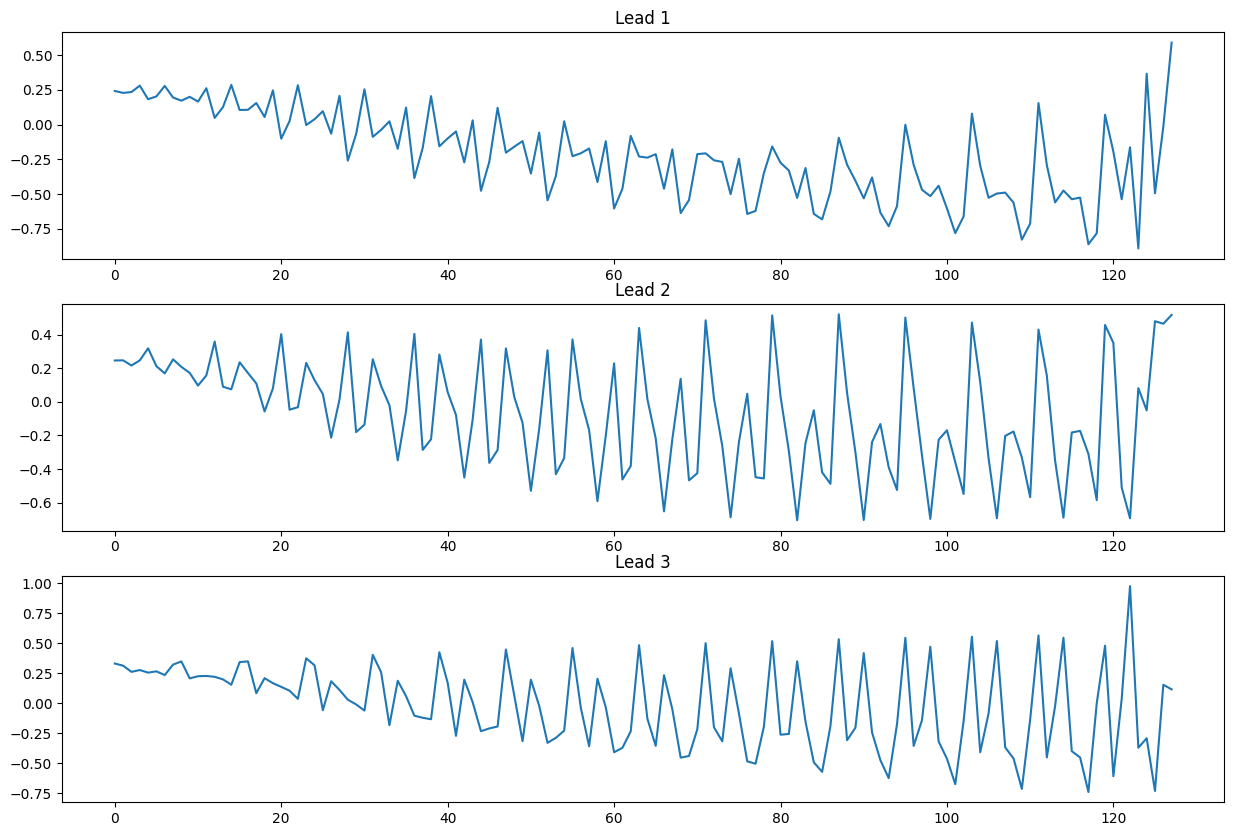

Checkpoint saved at epoch 100: ./checkpoints/ckpt-100
Epoch 100 | D Loss: Real=0.7173, Fake=0.7176 | G Loss=0.6092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 110 | D Loss: Real=0.7162, Fake=0.7164 | G Loss=0.6109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 120 | D Loss: Real=0.7152, Fake=0.7154 | G Loss=0.6129
1/1

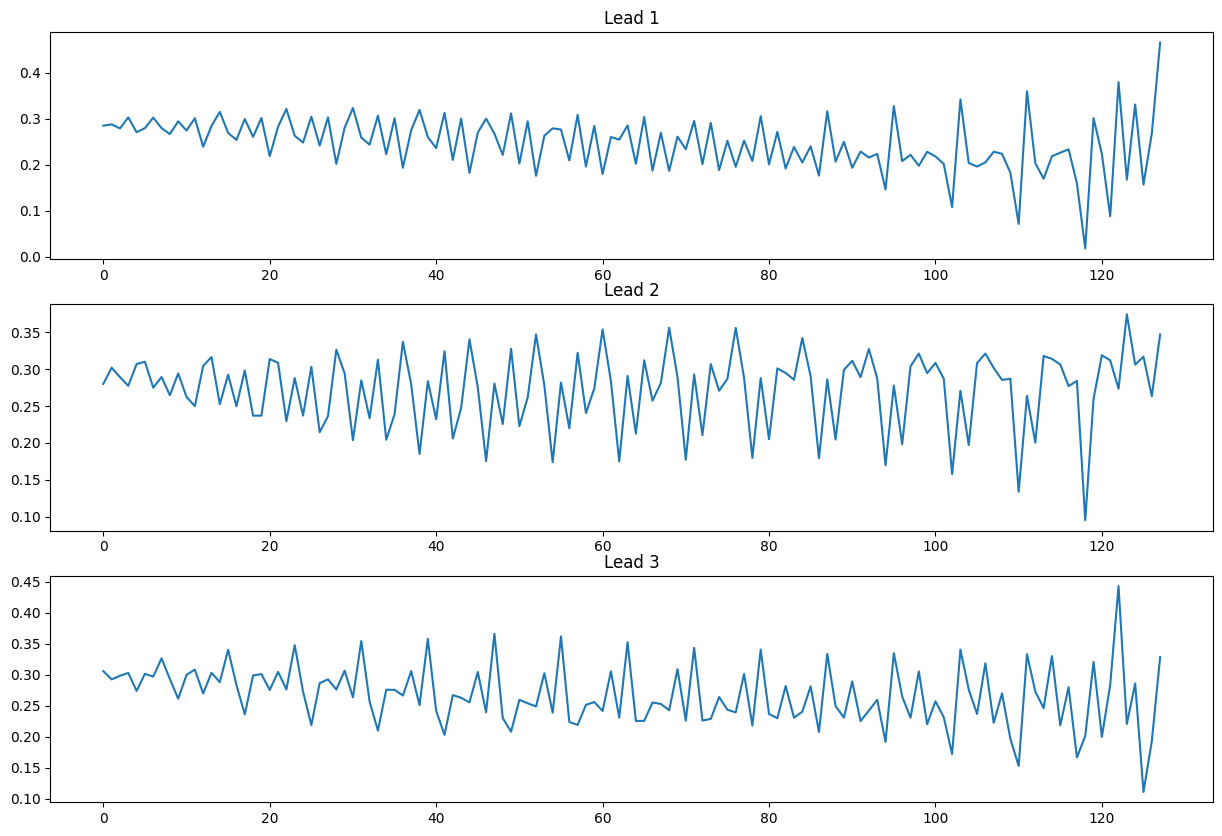

Checkpoint saved at epoch 150: ./checkpoints/ckpt-150
Epoch 150 | D Loss: Real=0.7123, Fake=0.7124 | G Loss=0.6188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 160 | D Loss: Real=0.7114, Fake=0.7115 | G Loss=0.6207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 170 | D Loss: Real=0.7105, Fake=0.7106 | G Loss=0.6223
1/1

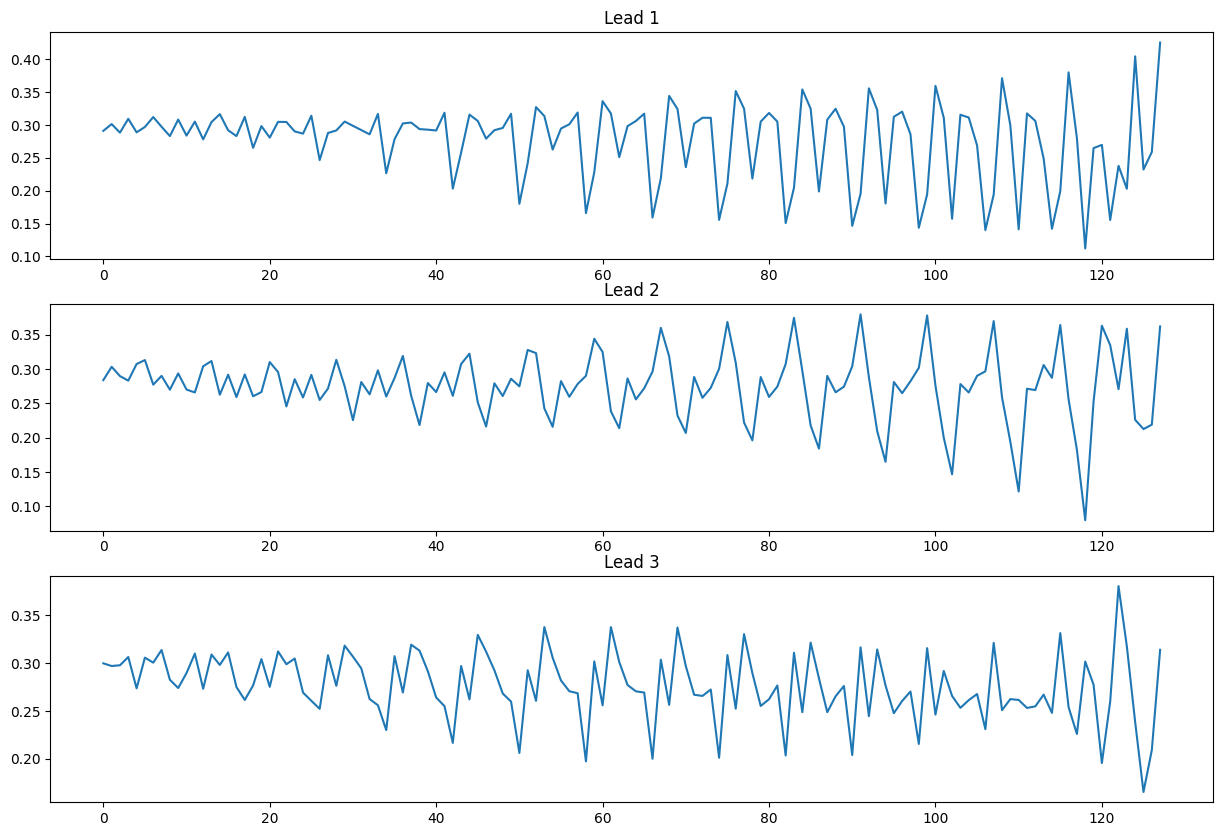

Checkpoint saved at epoch 200: ./checkpoints/ckpt-200
Epoch 200 | D Loss: Real=0.7077, Fake=0.7078 | G Loss=0.6265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 210 | D Loss: Real=0.7069, Fake=0.7070 | G Loss=0.6274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 220 | D Loss: Real=0.7063, Fake=0.7064 | G Loss=0.6287
1/1

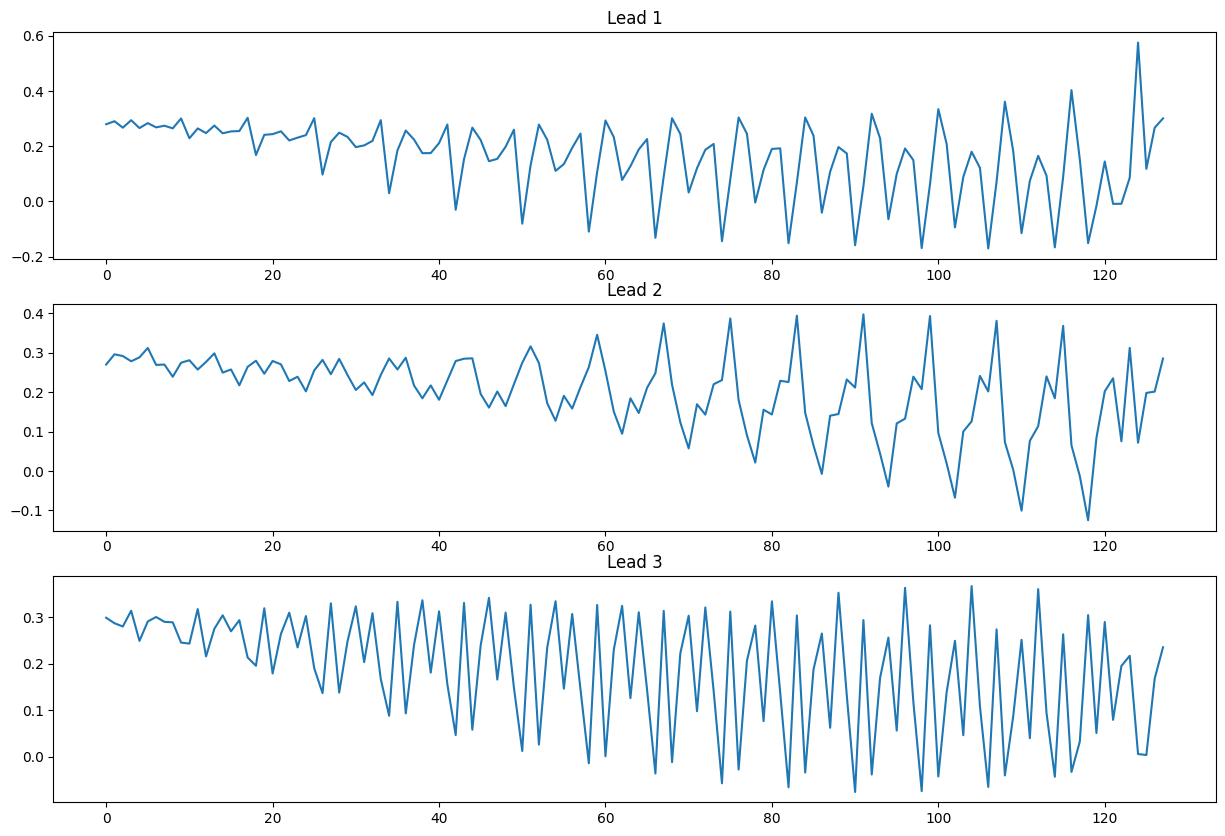

Checkpoint saved at epoch 250: ./checkpoints/ckpt-250
Epoch 250 | D Loss: Real=0.7050, Fake=0.7052 | G Loss=0.6305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 260 | D Loss: Real=0.7049, Fake=0.7050 | G Loss=0.6307
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 270 | D Loss: Real=0.7045, Fake=0.7046 | G Loss=0.6311
1/1

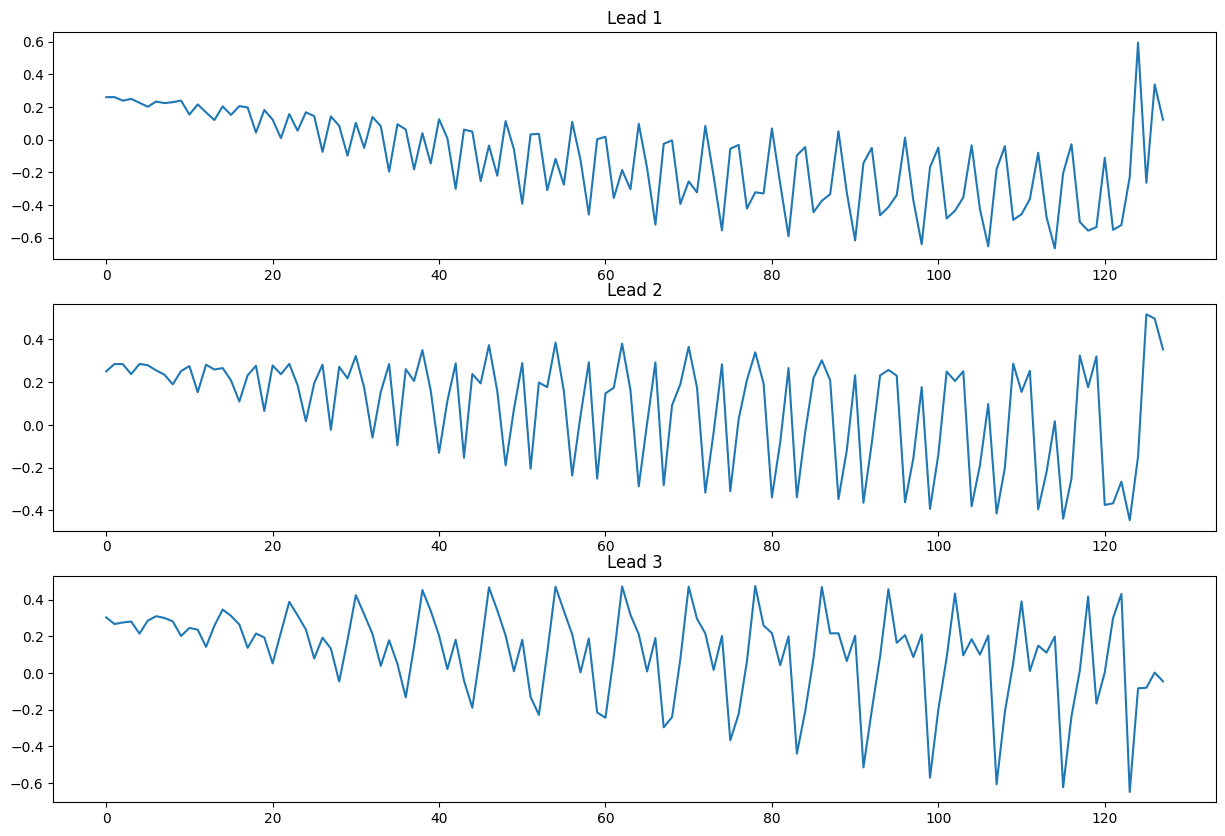

Checkpoint saved at epoch 300: ./checkpoints/ckpt-300
Epoch 300 | D Loss: Real=0.7033, Fake=0.7033 | G Loss=0.6332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 310 | D Loss: Real=0.7027, Fake=0.7027 | G Loss=0.6343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 320 | D Loss: Real=0.7020, Fake=0.7020 | G Loss=0.6355
1/1

KeyboardInterrupt: 

In [8]:
generator = build_generator()
discriminator = build_discriminator()
gen_optimizer = Adam(learning_rate=1e-4, beta_1=0.5)
disc_optimizer = Adam(learning_rate=1e-5, beta_1=0.5)
# gen_optimizer = RMSprop(0.002)
# disc_optimizer = RMSprop(0.002)

checkpoint_dir = "./checkpoints"

checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    generator_optimizer=gen_optimizer,
    discriminator_optimizer=disc_optimizer
)

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    checkpoint_dir,
    max_to_keep=5
)

if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print(f"Checkpoint restored from: {checkpoint_manager.latest_checkpoint}")

train_gan(generator, discriminator, gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer, checkpoint_manager=checkpoint_manager, dataset=normalized_ecg_dataset, batch_size=32)